# **Miniproject 2**
## **~Large~ Small Language Model**

### **Objective**
Implement a transformer-based, character-level language model (GPT-like) and train it on the Shakespeare dataset. By the end of this project, you should be able to generate Shakespearean-like text given a seed string.

You will probably want to train the model on a GPU. You can use free GPUs on [Google Colab](https://colab.research.google.com/?utm_source=scs-index).

### **Dataset**:

The Shakespeare dataset contains the complete works of William Shakespeare, including his plays, poems, and sonnets.

[**Download link**](https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt)

In a character-level language model, each character in the input data is mapped to its respective index from a dictionary. The input to the model is in the form (B, N), where B is the batch size and N is the number of tokens for each sequence. The model was tested with B=N=128, but feel free to explore different values.

An interface for the dataset class that takes care of tokenization is provided below.



```python
from torch.utils.data import Dataset

class CharDataset(Dataset):
    """
    Emits batches of characters.

    Adapted from "https://github.com/karpathy/minGPT".
    """

    def __init__(self, config, data):

        chars = ... # get characters from the input data
        self.stoi = { ch:i for i,ch in enumerate(chars) } # map characters to integer indices

        ...

    def get_vocab_size(self):
        raise NotImplementedError()

    def __len__(self):
        raise NotImplementedError()

    def __getitem__(self, idx):
        # grab a chunk of (block_size + 1) characters from the data
        # encode every character to an integer
        # return the chunk and the shifted version as tensors
        pass
```




### **Requirements**

#### **Architecture**

Implement the Transformer's decoder-only structure.
This includes

* input token embeddings
* the causal multi-head self-attention mechanism
* feed-forward neural networks
* positional encodings, residual connections, layer normalizations.

The project was tested with $12$ layers, $8$ attention heads, and $768$ embedding dimensions, on a single GPU.

The `forward` method for the entire model has the following form:

```
tok_emb = WTE(idx) # token embeddings
pos_emb = WPE(pos) # position embeddings
x = Dropout(tok_emb + pos_emb)
for Block in Blocks:
    x = Block(x)
x = Final_LayerNorm(x)
logits = LM_Head(x)
```

The `forward` method for the transformer block has the following form:



```
x = x + self.CausalSelfAttn(self.LayerNorm_1(x))
out = x + self.MLP(self.LayerNorm_2(x))
```

---

#### **Training**

In a character-level transformer language model, the goal is to predict the next character in a sequence given the previous characters. To train such a model effectively, we use two versions of our data: the input sequence and a shifted version of this sequence, which serves as the target for our predictions.

Preprocess the dataset to a character-level representation.
Use a sliding window approach for sequence chunks (e.g., window size of $128$ characters).
Implement causal masking for the self-attention mechanism.
Use the [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) optimizer and the cross-entropy loss.

**Optional**:

* Implement a learning rate decay strategy
* Implement gradient clipping

---


#### **Evaluation and Inference**

* Monitor the cross-entropy loss. Use a seed string to initialize the model and generate Shakespearean-like text.

* In order to generate the characters, at each generation step you can either select the character with the highest probability, or you can sample according to the output distribution.

The high-level pseudocode for generation is:

```python
model.eval()
with torch.no_grad():
    context = "O God, O God!"
    tokenized_context = tokenize(context)
    # the model should implement a method to generate tokens given a prompt
    y = model.generate(tokenized, ...)
    completion = tokens_to_string(y)
```

**Optional**:
* Compute the [perplexity](https://medium.com/@priyankads/perplexity-of-language-models-41160427ed72#:~:text=Intuitively%2C%20perplexity%20means%20to%20be,loss%20obtained%20from%20the%20model.) metric for quantitative evaluation.

### **Example Outputs**

The following are my outputs after $6000$ steps of training, with the seed string "O God, O God!"



```
O God, O God! neither? unto the base very ears,
As damned with it.

DUKE OF YORK:
Away! Once more, one word.

RICHARD:
Clove, dear so; and therein my son will be
false of woe: if ye seems to be the mother
Of gracious order this time when R going kinsperse eyes,
What dost bewreck her fairer drying tears.

NORTHUMBERLAND:
Have you forgot the Duke of Norfolk, get him to
again; and and agilic: there is my spirit
So maly did must such a marble perfection.

ELBOW:
Come, bring them with oaths, and so deliver
```


### Resources:

* Vaswani et al., "Attention is All You Need": [link](https://arxiv.org/abs/1706.03762)

* Illustrated Transformer by Jay Alammar: [link](https://jalammar.github.io/illustrated-transformer/)

* OpenAI GPT-2 Paper: [link](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

* Deep Learning Course slides on transformers: [link](https://fleuret.org/dlc/materials/dlc-handout-13-3-transformers.pdf)

# _____________________________________________________________________________
Lea Heiniger  
December 2024  

# Implementation

In [91]:
## Imports
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

print(torch.cuda.is_available()) # test if cuda is usable
global device

if torch.cuda.is_available() :

    device = 'cuda'

else :

    device = 'cpu'

# import input.txt
#from google.colab import files
#uploaded = files.upload()

True


## Classes and Functions

In [92]:
## Data and Tokenisation

def get_data_from_file(filename : str) -> str :

    ## Reads the Input File and Returns the Content as a String ##


    with open(filename, 'r') as f :

        data = f.read()

    return data


class CharDataset(Dataset):
    """
    Emits Batches of Characters.

    Adapted from "https://github.com/karpathy/minGPT".
    """

    def __init__(self, config : dict, data : str) :

        self.data = data
        chars = sorted(set(data)) # get characters from the input data
        self.stoi = {ch : i for i,ch in enumerate(chars)}  # map characters to integer indices
        self.itos = {i : ch for i, ch in enumerate(chars)} # char to int (used for tokens_to_string())
        self.batch_size = config['batch_size']

    def get_vocab_size(self) -> int :

        vocab_size = len(self.stoi)

        return vocab_size

    def __len__(self) -> int :

        length = len(self.data)-self.batch_size

        return length

    def __getitem__(self, idx : int) -> tuple[torch.Tensor, torch.Tensor] :

        # grab a chunk of (block_size + 1) characters from the data
        char_chunk = self.data[idx:idx+self.batch_size+1]

        # encode every character to an integer
        integer_chunk = [self.stoi[ch] for ch in char_chunk]

        # return the chunk and the shifted version as tensors
        X = torch.tensor(integer_chunk[:-1])
        Y = torch.tensor(integer_chunk[1:])

        return X, Y

    def tokenize(self, string: str) -> list[int] :

        ## Tokenizes a String ##

        # return tokenized as a list of tokens (int)
        tokenized = [self.stoi[ch] for ch in string if ch in self.stoi]

        return tokenized

    def tokens_to_string(self, tokens: list[int]) -> str :

        ## Convert the List of Tokens to a String ##

        string = ''.join([self.itos[token] for token in tokens])

        return string


In [93]:
## Positional Encoding

class PositionalEncodings(nn.Module) :
    '''
    Computes and Store the Positional Encodings.
    '''

    def __init__(self, config : dict) :
        super().__init__()

        pos = torch.tensor([n for n in range(config['max_tokens'])], dtype = torch.float32)
        pos = torch.unsqueeze(pos, 1)
        i = torch.tensor([n for n in range(0, config['WE_dim'], 2)], dtype = torch.float32)

        # PE_pos2i = sin(pos/10000^(2i/WE_dim))
        # PE_pos2i+1 = cos((pos/10000^(2i/WE_dim))
        PE = np.zeros((config['max_tokens'], config['WE_dim']), dtype = np.float32)
        PE[:, 0::2] = np.sin(pos/(10000**(2*i/config['WE_dim']))) # all even col
        PE[:, 1::2] = np.cos(pos/(10000**(2*i/config['WE_dim']))) # all odd col
        PE = torch.tensor(PE, dtype = torch.float32)

        self.register_buffer('PE', PE)

    def forward(self, WE : torch.Tensor) -> torch.Tensor :

        ## Adds Positional Encodings to the Word Embeddings ##

        PE = self.PE.to(device)

        return WE+self.PE[:WE.size(0), :]


In [94]:
## Transformer Block

class CSAttention(nn.Module) :
    '''
    Causal Multi-Headed Self-Attention
    '''

    def __init__(self, config : dict) :
        super().__init__()

        # config parmeters
        self.WE_dim = config['WE_dim']
        self.n_heads = config['n_heads']
        self.batch_size = config['batch_size']
        self.seq_len = config['seq_len']
        self.heads_dim = self.WE_dim // self.n_heads

        # querry, key, value
        self.Q = nn.Linear(self.WE_dim, self.WE_dim)
        self.K = nn.Linear(self.WE_dim, self.WE_dim)
        self.V = nn.Linear(self.WE_dim, self.WE_dim)

        self.scale = torch.sqrt(torch.tensor([self.heads_dim], dtype = torch.float32))
        self.dropout = nn.Dropout(config['dropout'])
        self.out_proj = nn.Linear(self.WE_dim, self.WE_dim)

    def causal_mask(self, seq_len : int) -> torch.Tensor :

        ## Computes Causal Mask ##

        # size (1, 1, config['seq_len'], config['seq_len'])
        mask = torch.tensor(np.ones((self.seq_len, self.seq_len)))
        mask = torch.tril(mask)
        mask = torch.unsqueeze(torch.unsqueeze(mask, 0), 0)

        return mask

    def forward(self, x: torch.Tensor) -> torch.Tensor :

        ## Computes the Output of the Causal Self-Attention Mechanism ##

        # resize Q K V for multi-head
        # size (batch_size, self.n_heads, seq_len, self.heads_dim)
        Q = self.Q(x).to(device)
        K = self.K(x).to(device)
        V = self.V(x).to(device)
        Q = torch.transpose(Q.view(self.batch_size, self.seq_len, self.n_heads, self.heads_dim), 1, 2)
        K = torch.transpose(K.view(self.batch_size, self.seq_len, self.n_heads, self.heads_dim), 1, 2)
        V = torch.transpose(V.view(self.batch_size, self.seq_len, self.n_heads, self.heads_dim), 1, 2)

        # attention computation
        # E_ij = (Q_i*K_j)/scale
        energy = torch.matmul(Q, torch.transpose(K, -2, -1))/self.scale.to(device)
        mask = self.causal_mask(self.seq_len).to(device)
        energy = energy.masked_fill(mask == 0, float('-inf'))

        # AW_ij = softmax(E_ij)
        attention = torch.softmax(energy, dim = -1)
        attention = self.dropout(attention)

        out = torch.matmul(attention, V)

        # combine heads
        out = torch.transpose(out, 1, 2).contiguous().view(self.batch_size, self.seq_len, self.WE_dim)
        out = self.out_proj(out)

        return out


class TransformerBlock(nn.Module) :
    '''
    Transformer Block with
    Causal Multi-Headed Self-Attention,
    Dropout,
    Multi-Layer Perceptron (Feed-Forward Neural Network)
    and Layer Normalization
    '''

    def __init__(self, config : dict) :
        super().__init__()

        # multi-headed causal self-attention
        self.CausalSelfAttn = CSAttention(config)

        # dropout
        self.dropout = nn.Dropout(config['dropout'])

        # feed-forward neural network
        self.MLP = nn.Sequential(nn.Linear(config['WE_dim'], config['FFN_dim']), nn.ReLU(), nn.Linear(config['FFN_dim'], config['WE_dim']))

        # layer normalization
        self.LayerNorm_1 = nn.LayerNorm(config['WE_dim'])
        self.LayerNorm_2 = nn.LayerNorm(config['WE_dim'])

    def forward(self, x : torch.Tensor) -> torch.Tensor :

        ## Computes Residual Connections, Attention and MLP ##

        x = x + self.CausalSelfAttn(self.LayerNorm_1(x))
        out = x + self.MLP(self.LayerNorm_2(x))

        return out


In [95]:
## Transformer Model

class TransformerModel(nn.Module) :
    '''
    The Decoder Only Transformer Model
    '''

    def __init__(self, config : dict) :
        super().__init__()

        self.WE_dim = config['WE_dim']
        self.n_layers = config['n_layers']
        self.vocab_size = config['vocab_size']

        self.WTE = nn.Embedding(self.vocab_size, self.WE_dim)
        self.WPE = PositionalEncodings(config)

        self.dropout = nn.Dropout(config['dropout'])
        self.Blocks = nn.ModuleList([TransformerBlock(config) for _ in range(self.n_layers)])
        self.Final_LayerNorm = nn.LayerNorm(self.WE_dim)
        self.LM_Head = nn.Linear(self.WE_dim, self.vocab_size)

    def forward(self, idx: torch.Tensor) -> torch.Tensor :

        ## Generates Logits for Each Token ##

        # embeddings
        tok_emb = self.WTE(idx)
        pos_emb = self.WPE(tok_emb)
        x = self.dropout(tok_emb + pos_emb)

        # transformer block
        for Block in self.Blocks:

            x = Block(x)

        x = self.Final_LayerNorm(x)
        logits = self.LM_Head(x)

        return logits

    def generate(self, tokenized : list[int], config : dict) -> list[int] :

        ## Generate a List of Tokens Given a Prompt ##

        input_seq = torch.unsqueeze(torch.tensor(tokenized, dtype = torch.long), 0).to(device)
        gen_tokens = tokenized
        self.to(device)

        # generate characters
        for _ in range(config['max_len']):

            logits = self.forward(input_seq)
            next_logits = logits[:, -1, :]
            next_logits = next_logits/config['temperature'] # if temperature = 1.0 nothing changes

            # select the token with the highest probability
            probas = torch.softmax(next_logits, dim = -1)
            next_token = torch.argmax(probas, 1)
            next_token = torch.unsqueeze(next_token, 0).to(device)

            input_seq = torch.cat([input_seq, next_token], dim = 1)
            config['seq_len'] += 1

            gen_tokens.append(next_token.item())


        return gen_tokens


In [96]:
## Trainig Function

def train(model : TransformerModel, dataset : CharDataset, config : dict) -> tuple[TransformerModel, list] :

    ## Trains the Model with Adam Optimizer and Stores Cross-Entropy Loss ##

    train_loader = DataLoader(dataset, batch_size = config['batch_size'], shuffle=True)

    # adam optimizer and cross-entropy loss
    optimizer = optim.Adam(model.parameters(), lr = config['learning_rate'])
    loss_fn = nn.CrossEntropyLoss()

    model.train()

    monitor_loss = []
    steps_count = 0

    for epoch in range(config['epochs']):

        print('Epoch', epoch+1)
        total_loss = 0
        steps_loss = [] # store the cross-entropy loss at each step

        for batch_idx, (X, Y) in enumerate(train_loader) :

            X, Y = X.to(torch.int64), Y.to(torch.int64)
            X, Y = X.to(device), Y.to(device)
            optimizer.zero_grad()
            logits = model(X)
            loss = loss_fn(logits.view(-1, model.vocab_size), Y.view(-1))
            total_loss += loss.item()
            steps_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            steps_count += 1

            # monitor steps progression
            if steps_count%50 == 0 :

                print('Computed step', steps_count)

            if config['max_steps'] != None :

                # stop training ifwe reach max_steps
                if steps_count == config['max_steps'] :

                    monitor_loss.append(steps_loss)
                    print('Maximum number of steps reached')

                    return model, monitor_loss

        monitor_loss.append(steps_loss)

    return model, monitor_loss


## Model Training

In [97]:
# model configuration
config = {'WE_dim': 768,
          'n_heads': 8,
          'n_layers': 12,
          'batch_size': 128,
          'seq_len': 128,
          'FFN_dim': 1024,
          'dropout': 0.1,
          'learning_rate': 1e-3,
          'max_tokens': 256,
          'temperature': 1.0,
          'max_steps': 3000} # Optional : set to None if we don't want to stop training after reaching max_steps steps


## Retrieve Data from the File 'input.txt' ##

data = get_data_from_file('input.txt')
dataset = CharDataset(config, data)

config['vocab_size'] = dataset.get_vocab_size()
config['n_train_samp'] = len(dataset)
config['epochs'] = 1
#steps_per_epoch = config['n_train_samp']//config['batch_size']
#config['epochs'] = int(np.ceil(config['max_steps']/steps_per_epoch))


In [98]:

## Trains the Model with the Configuration 'config' ##

model = TransformerModel(config).to(device)
model, monitor_loss = train(model, dataset, config)

# saves the model
torch.save(model.state_dict(), 'model_'+str(config['max_steps'])+'steps.pth')


Epoch 1
Computed step 50
Computed step 100
Computed step 150
Computed step 200
Computed step 250
Computed step 300
Computed step 350
Computed step 400
Computed step 450
Computed step 500
Computed step 550
Computed step 600
Computed step 650
Computed step 700
Computed step 750
Computed step 800
Computed step 850
Computed step 900
Computed step 950
Computed step 1000
Computed step 1050
Computed step 1100
Computed step 1150
Computed step 1200
Computed step 1250
Computed step 1300
Computed step 1350
Computed step 1400
Computed step 1450
Computed step 1500
Computed step 1550
Computed step 1600
Computed step 1650
Computed step 1700
Computed step 1750
Computed step 1800
Computed step 1850
Computed step 1900
Computed step 1950
Computed step 2000
Maximum number of steps reached


## Evaluation

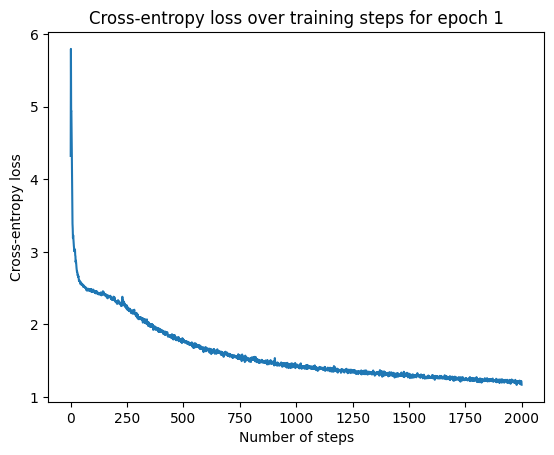

In [99]:
# graph of cross-entropy loss
for e in range(len(monitor_loss)) :

    x = [i for i in range(len(monitor_loss[e]))]
    y = monitor_loss[e]

    fig = plt.figure()
    plt.title('Cross-entropy loss over training steps for epoch '+str(e+1))
    plt.plot(x, y)
    plt.xlabel ('Number of steps')
    plt.ylabel ('Cross-entropy loss')

    # saving graph
    plt.savefig('cross-entropy_graph_'+str(config['max_steps'])+'steps')


## Generation  

For this part, my code has a problem that I have not been able to fix.
The generation works correctly when we generate one token per execution, but when we try to generate multiple tokens in one execution (config['max_len'] > 1) we get the error 'RuntimeError: shape '[1, n, 8, 96]' is invalid for input of size m'.
The problem is that even though I update seq_len in my loop after adding the new token to input_seq, the change is not taken into account until after 2 executions.
Unfortunately I have not found a way to fix this.

In [ ]:

## Generate Shakespearean-Like Text Given a Seed String ##

# loades the model
model = TransformerModel(config)
model.load_state_dict(torch.load('model_'+str(config['max_steps'])+'steps.pth'))

# Evaluation
model.eval()

with torch.no_grad() :

    context = "O God, O God!"
    tokenized_context = dataset.tokenize(context)

    config['batch_size'] = 1
    config['seq_len'] = len(tokenized_context)
    config['max_len'] = 1 # due to the error
    #config['max_len'] = config['seq_len']*20

    y = model.generate(tokenized_context, config)
    completion = dataset.tokens_to_string(y)

print(completion)

# save completion
filename = 'completion_'+str(config['max_steps'])+'steps.txt'

with open(filename, 'w') as f :

    f.write('context : \"'+context+'\"\nOutput : '+completion)
